In [1]:
import os
import fnmatch
import pandas as pd
import csv
import numpy as np
from pathlib import Path
import statsmodels.api as sm
from statsmodels.formula.api import ols

import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Definitions

analysis_path = os.path.dirname(os.getcwd())

In [3]:
"""
The function below was created specifically for the one-way ANOVA table results returned for Type II sum of squares
"""

def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

#anova_table(aov_table)

## Glucose normalized data

In [4]:
df = pd.read_excel(f'{analysis_path}/02_raw_processed/static_average_scans/SUV_values/02_Hemispheres_averaged/01a_activity_in_relevant_regions_glucose_normalized.xlsx', header = 0, engine = 'openpyxl')

In [5]:
regions = ['mPFC', 'OFC', 'visual_cortex', 'hippocampus', 'accumbens', 'striatum', 'thalamus', 'cerebellum', 'whole_brain']
regions_renamed = ['mPFC', 'OFC', 'visual cortex', 'hippocampus', 'NAc', 'striatum', 'thalamus', 'cerebellum', 'whole brain']


## create linear models and store in dictionary

In [6]:
region_dict = {} #stores key:value pairs 

for region in regions:
    x=df[region]
    region_dict[f'{region}_lm'] = ols('x ~ Treatment_Group', data=df).fit()


## Assumption check ANOVA

1. Independence
2. Normality

    -> stats.shapiro 
    -> or with plotting
3. Homogeneity of Variance
    -> e.g. Levene's test of homogeneity of variances

### 2. Testing normality

In [7]:
# normality test

shapiro_all = []
for region in regions:
    
    row_shapiro = stats.shapiro(region_dict[f'{region}_lm'].resid)
    shapiro = pd.DataFrame([row_shapiro], columns=row_shapiro._fields)
    shapiro.insert(loc=0, column='region', value=f'{region}')
    
    shapiro_all.append(shapiro)
shapiro_all = pd.concat(shapiro_all, axis=0)
    #print(f'{region}')
    #print(stats.shapiro(region_dict[f'{region}_lm'].resid))
    
shapiro_all

,region,statistic,pvalue
0,mPFC,0.978023,0.869880
0,OFC,0.946850,0.251444
0,visual_cortex,0.989310,0.995221
0,hippocampus,0.976255,0.833602
0,accumbens,0.971475,0.724259
0,striatum,0.987197,0.986944
0,thalamus,0.980619,0.916435
0,cerebellum,0.943549,0.214043
0,whole_brain,0.980509,0.914649


mPFC


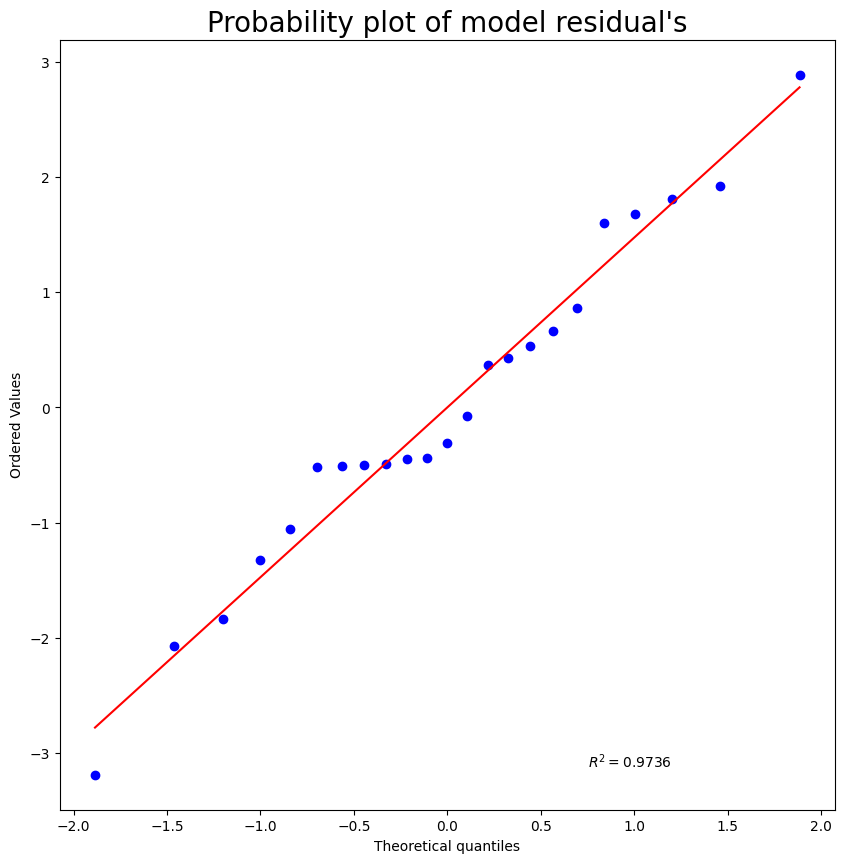

OFC


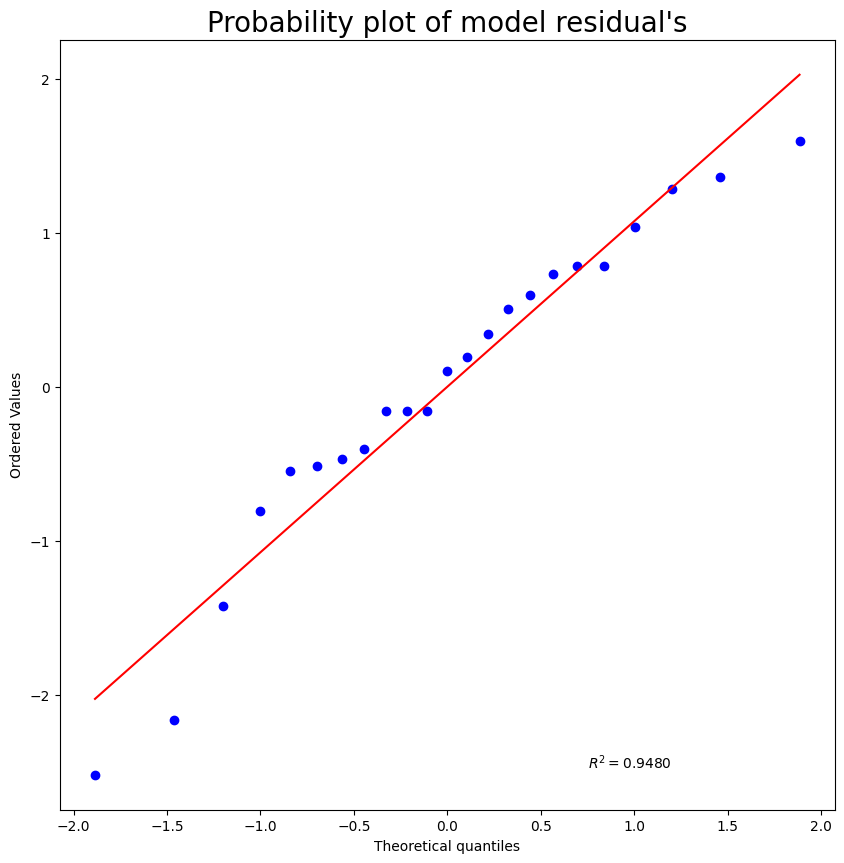

visual_cortex


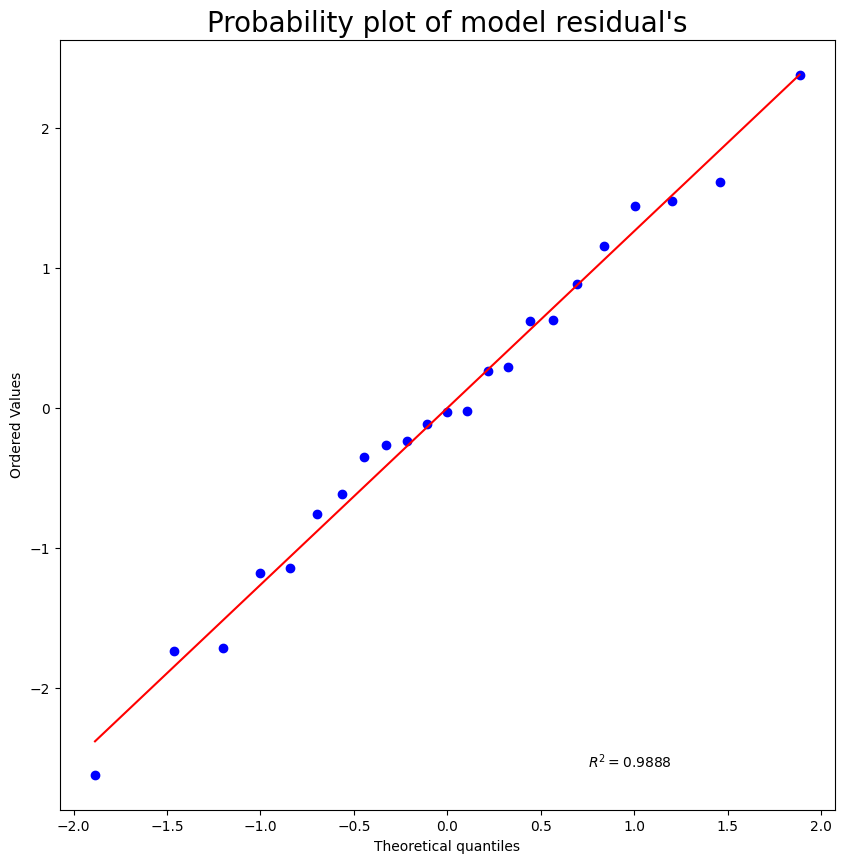

hippocampus


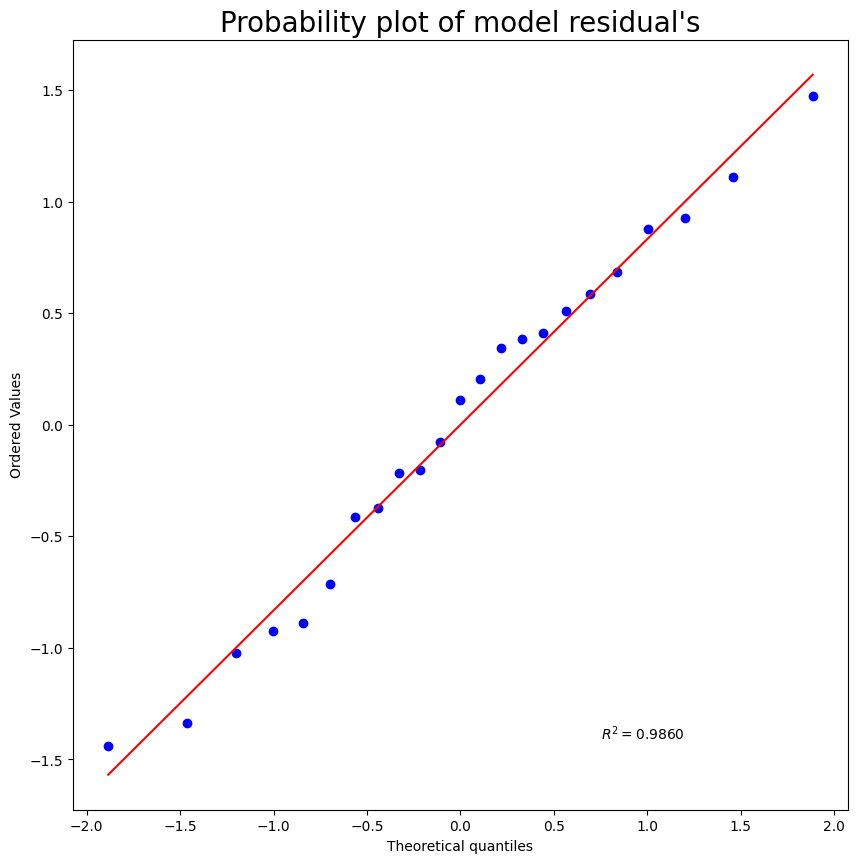

accumbens


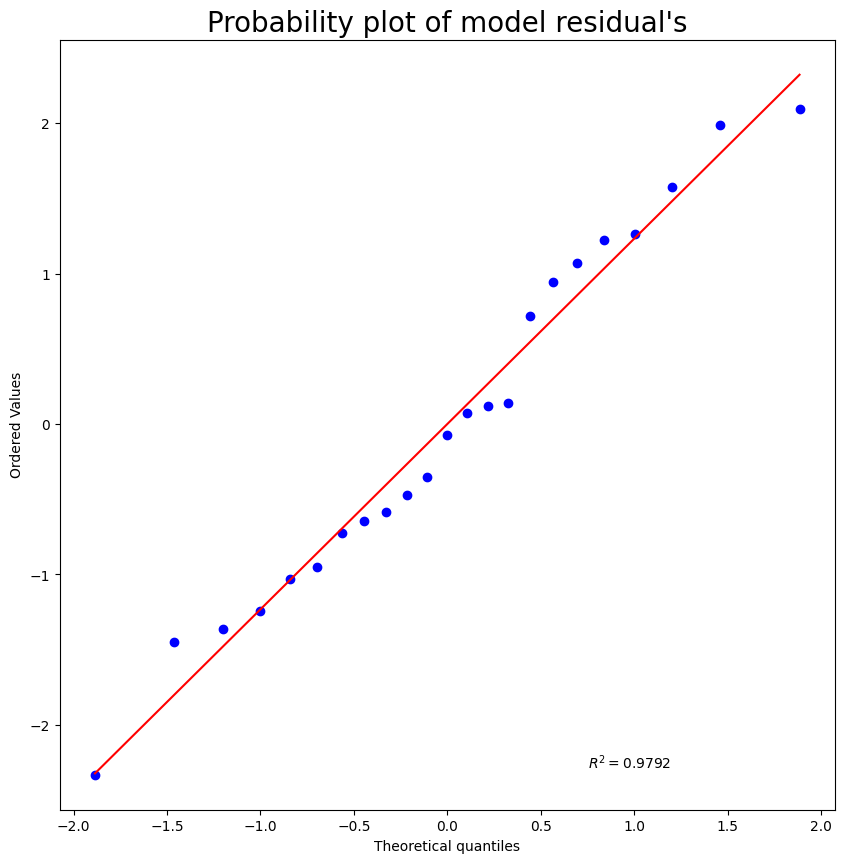

striatum


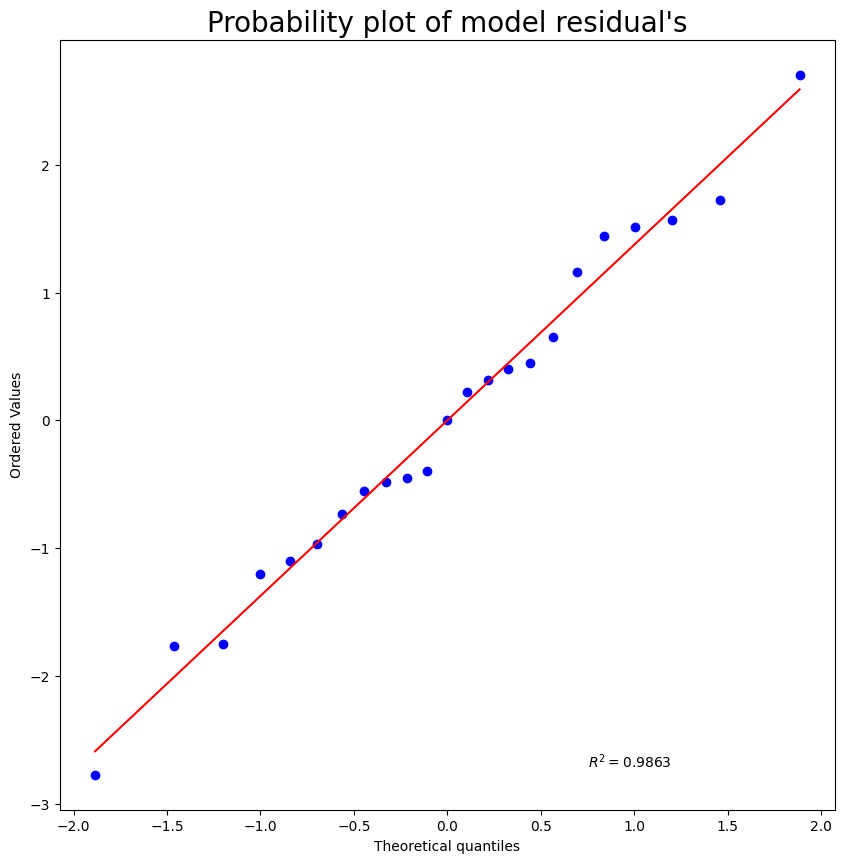

thalamus


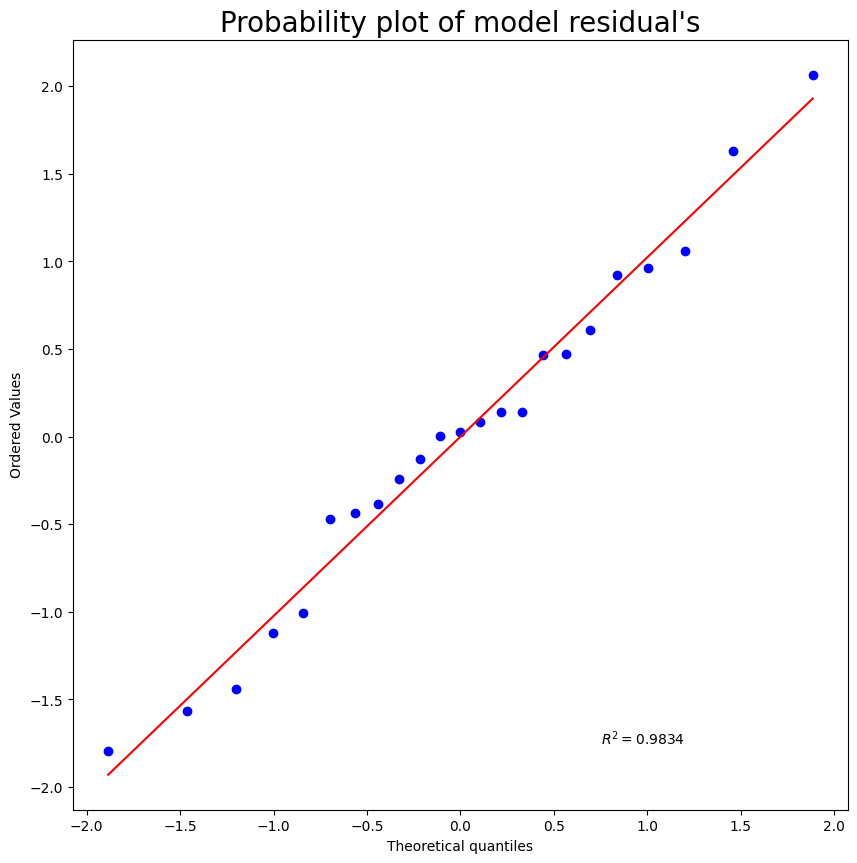

cerebellum


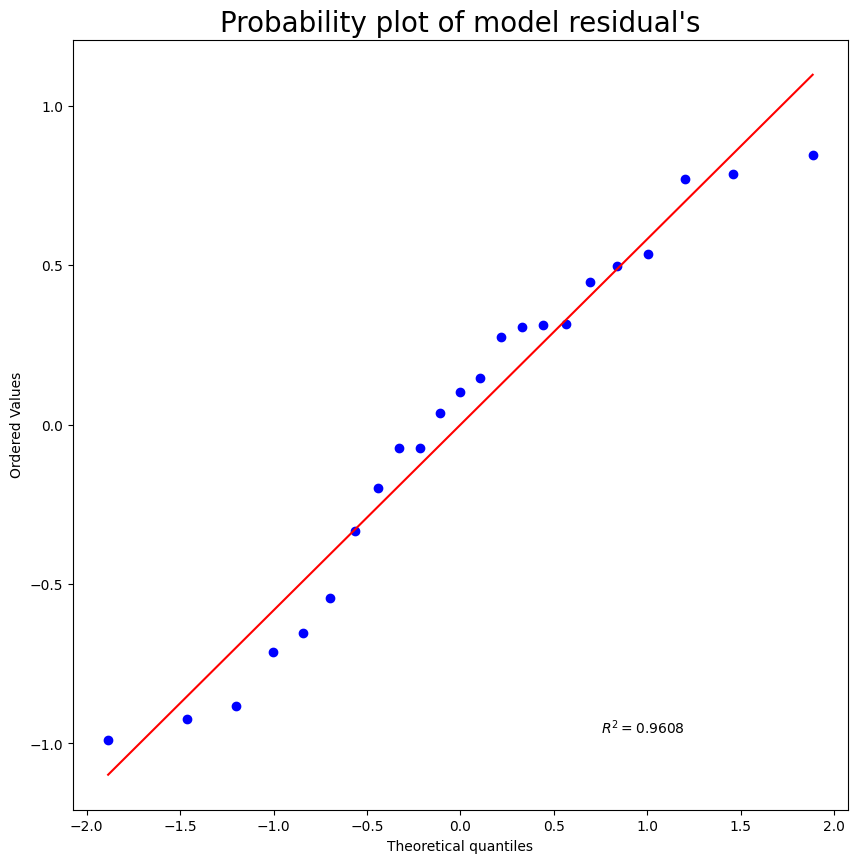

whole_brain


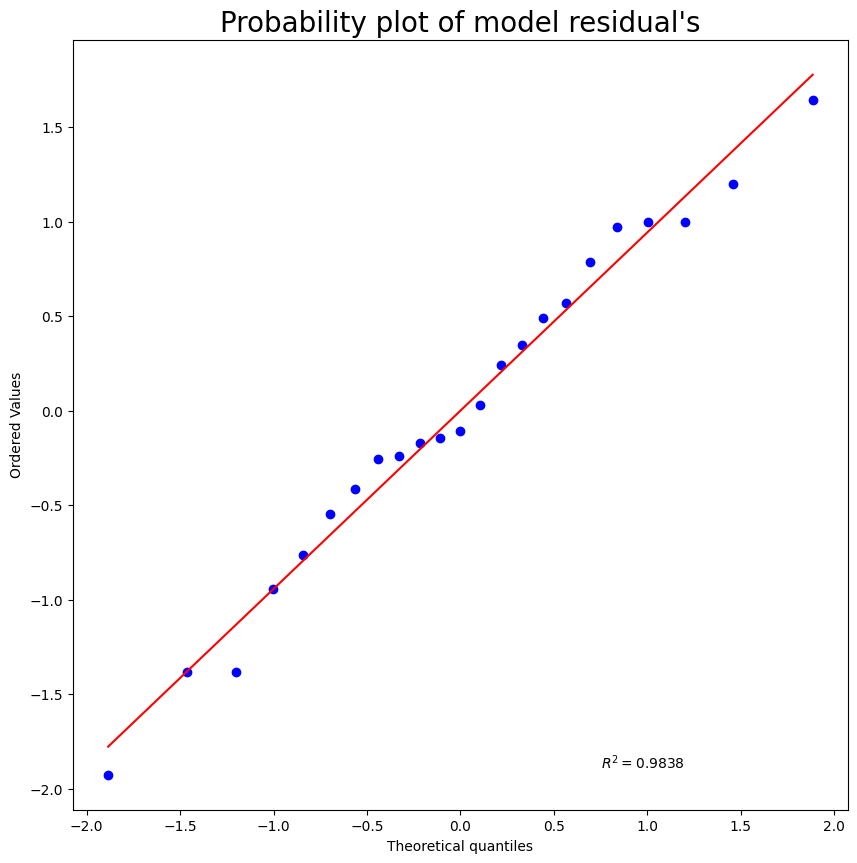

In [8]:
for region in regions:
    # with plotting 
    fig = plt.figure(figsize= (10, 10))
    ax = fig.add_subplot(111)

    normality_plot, stat = stats.probplot(region_dict[f'{region}_lm'].resid, plot= plt, rvalue= True)
    ax.set_title("Probability plot of model residual's", fontsize= 20)
    ax.set
    print(region)
    plt.show()

 #### -> no normality violations 

### 3. Testing Homogeneity of Variance

In [9]:
# homogeneity of variance testing

for region in regions:
    print(f'{region}')
    print(stats.levene(df[f'{region}'][df['Treatment_Group'] == 'Har + DMT'],
             df[f'{region}'][df['Treatment_Group'] == 'Har'],
             df[f'{region}'][df['Treatment_Group'] == 'DMT'],
             df[f'{region}'][df['Treatment_Group'] == 'Veh']))

mPFC
LeveneResult(statistic=1.2191410182319633, pvalue=0.32998460706046984)
OFC
LeveneResult(statistic=1.2366568005798166, pvalue=0.32403332967899645)
visual_cortex
LeveneResult(statistic=1.368640112827954, pvalue=0.28255229306322716)
hippocampus
LeveneResult(statistic=0.28016668498111474, pvalue=0.8390262201562904)
accumbens
LeveneResult(statistic=1.0215259657480087, pvalue=0.40517141773182763)
striatum
LeveneResult(statistic=0.9071299467847348, pvalue=0.45607727218803806)
thalamus
LeveneResult(statistic=0.2161236313471613, pvalue=0.883983678612634)
cerebellum
LeveneResult(statistic=0.2202134228248011, pvalue=0.8811493052935779)
whole_brain
LeveneResult(statistic=0.7026482162310912, pvalue=0.5620898786517694)


mPFC


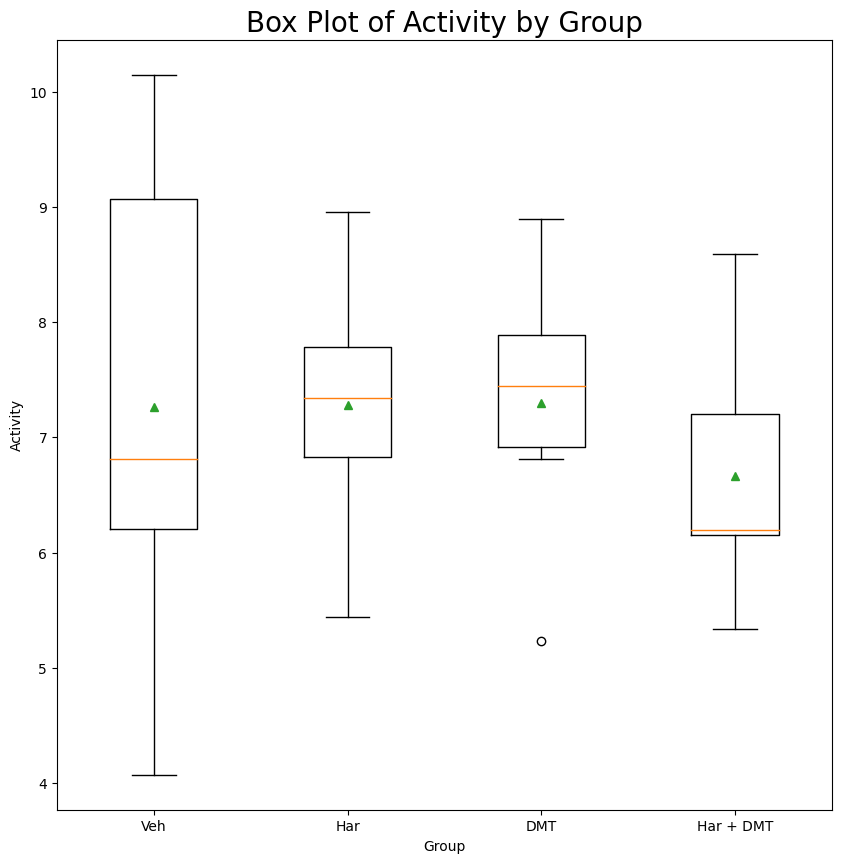

OFC


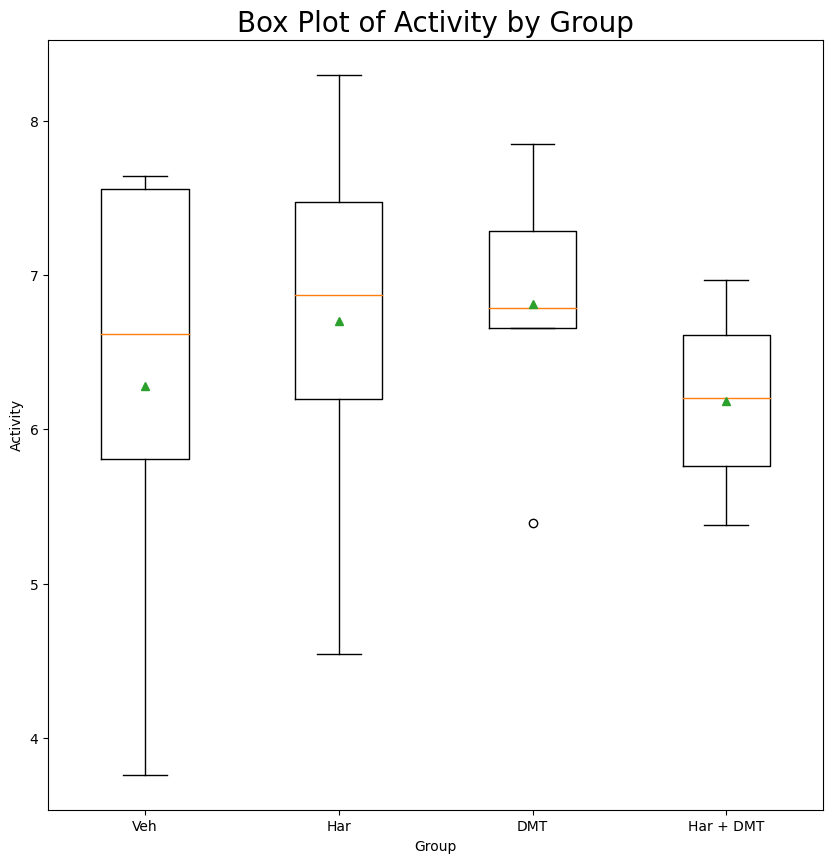

visual_cortex


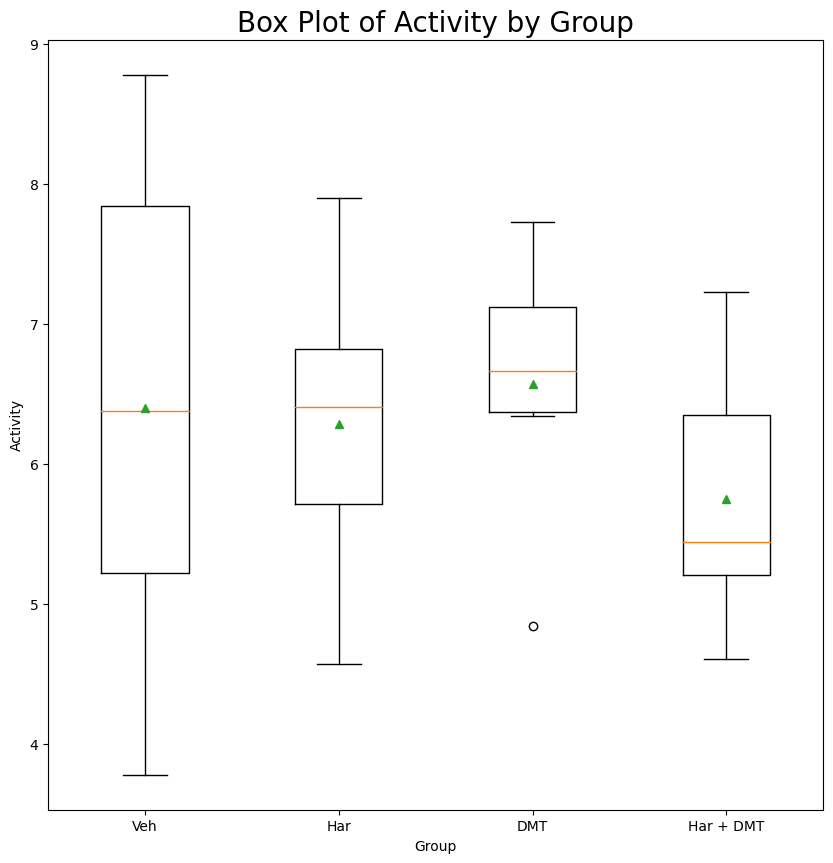

hippocampus


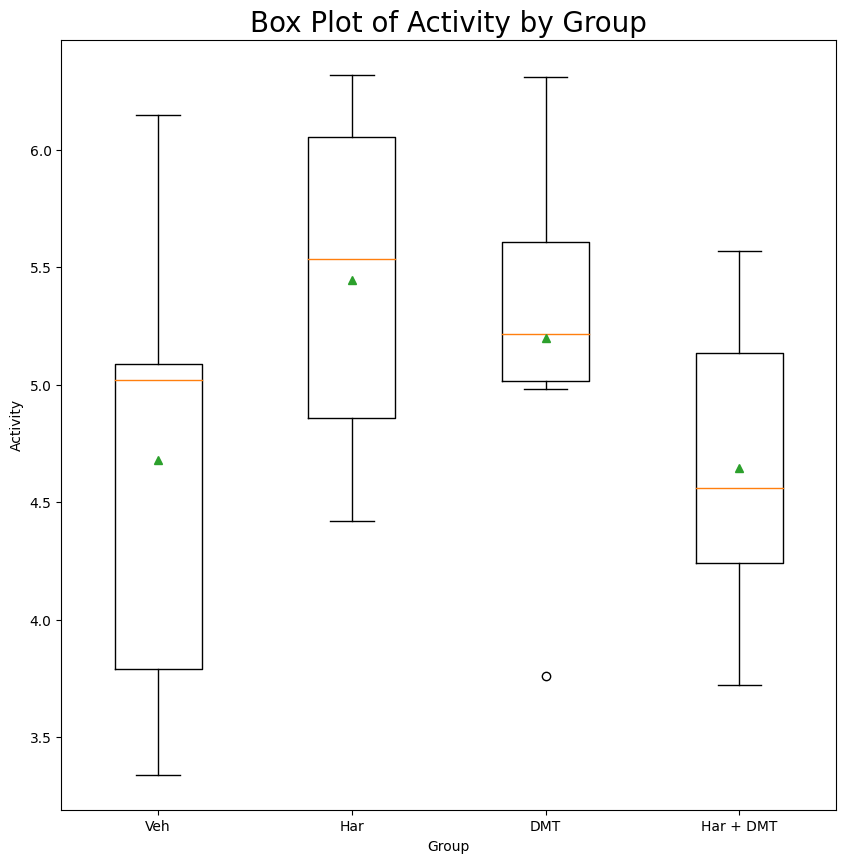

accumbens


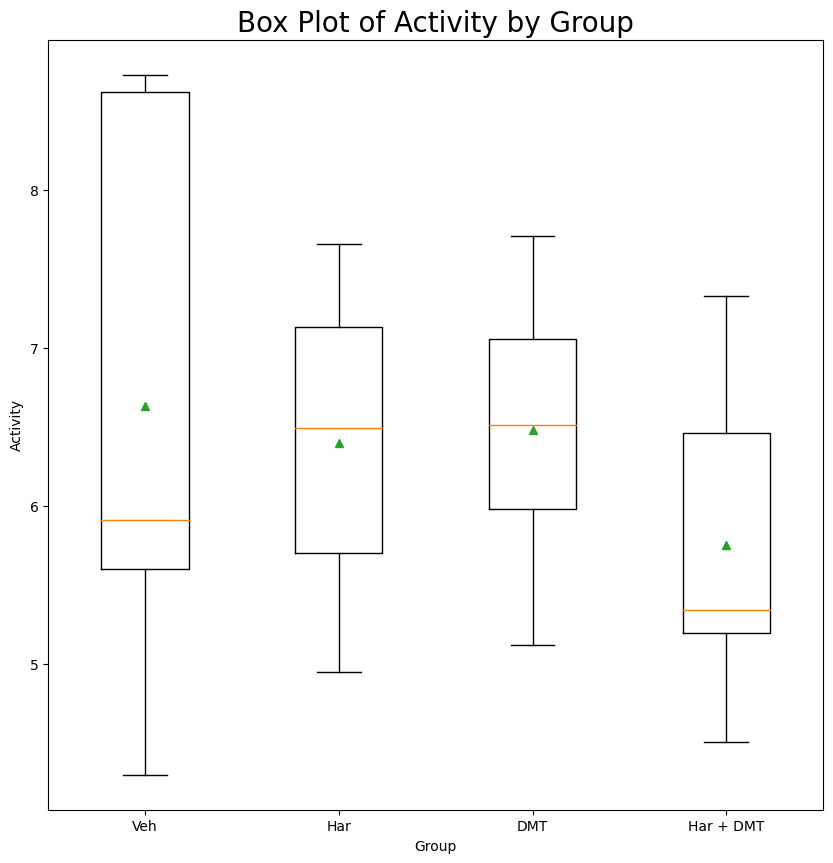

striatum


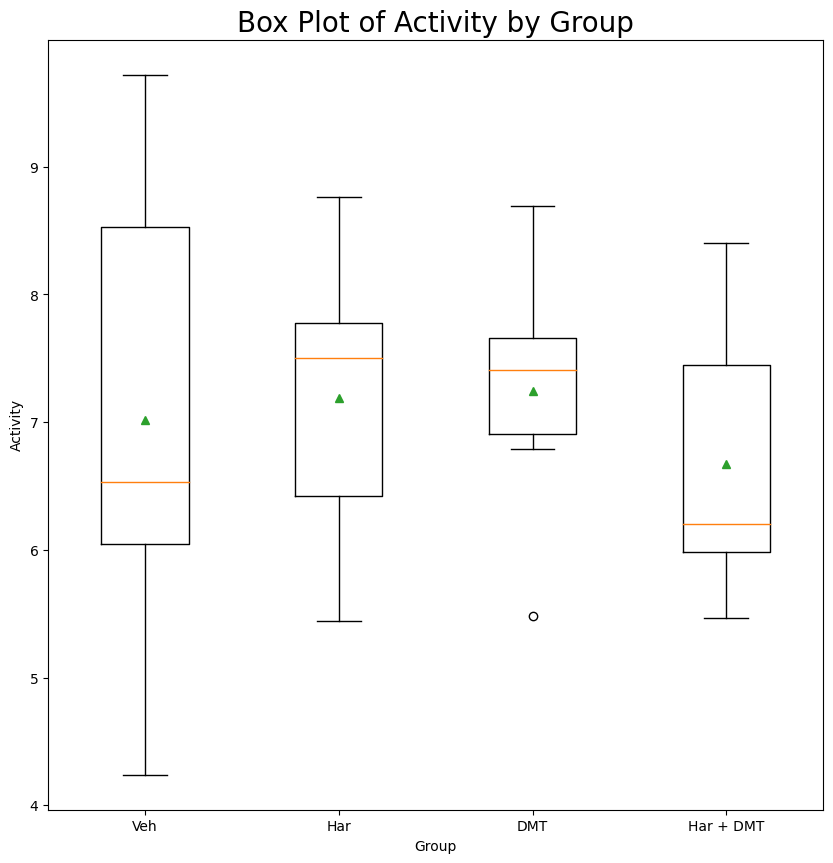

thalamus


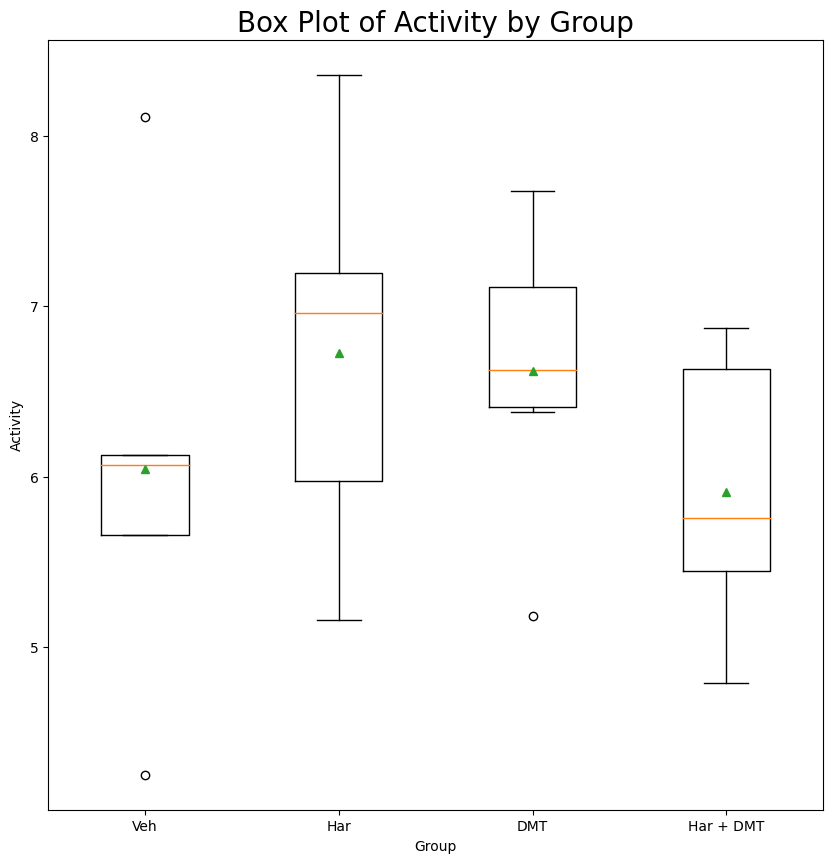

cerebellum


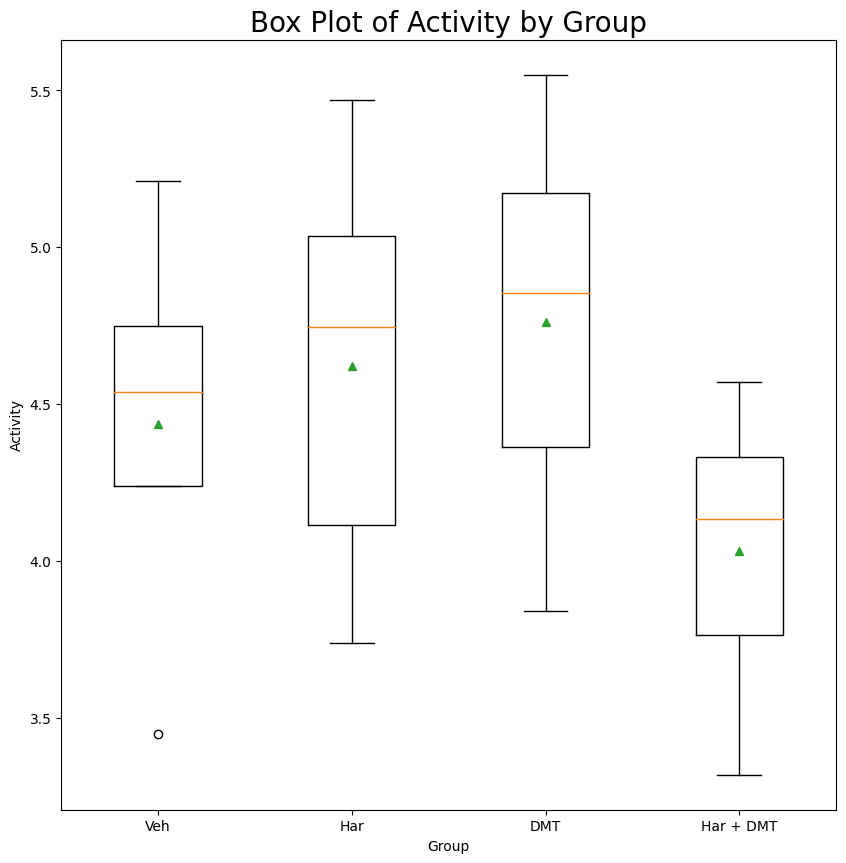

whole_brain


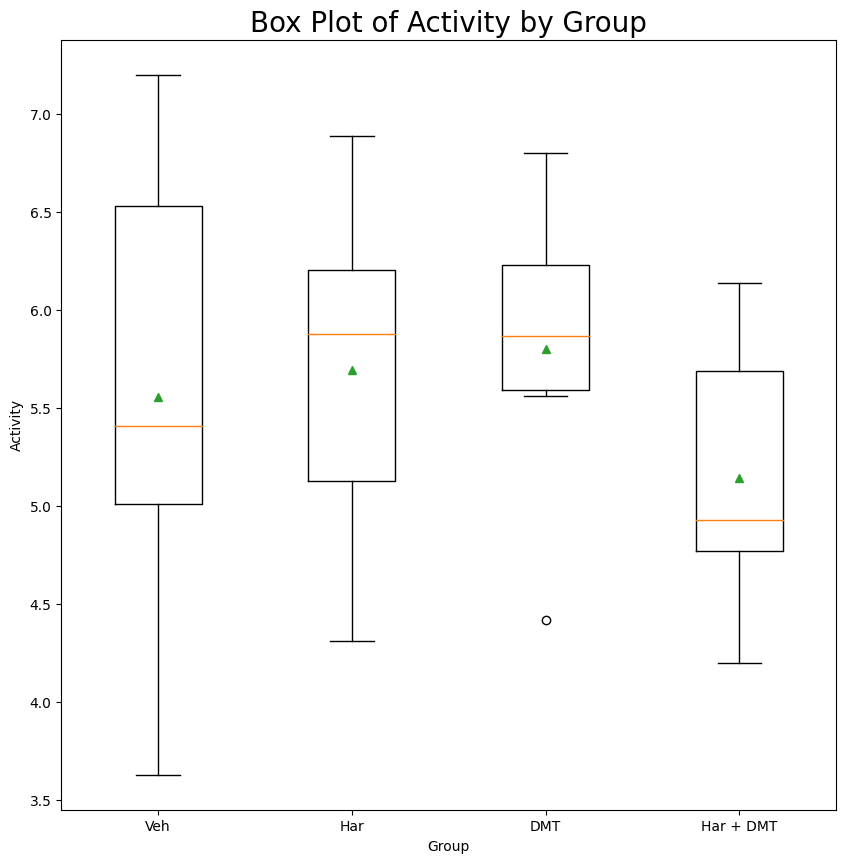

In [10]:
# visually testing
for region in regions:
    fig = plt.figure(figsize= (10, 10))
    ax = fig.add_subplot(111)

    ax.set_title("Box Plot of Activity by Group", fontsize= 20)
    ax.set

    data = [df[region][df['Treatment_Group'] == 'Veh'],
                 df[region][df['Treatment_Group'] == 'Har'],
                 df[region][df['Treatment_Group'] == 'DMT'],
                 df[region][df['Treatment_Group'] == 'Har + DMT']]

    ax.boxplot(data,
               labels= ['Veh', 'Har', 'DMT', 'Har + DMT'],
               showmeans= True)

    plt.xlabel("Group")
    plt.ylabel("Activity")
    
    print(region)
    plt.show()

-> testing homogeneity of Variance yields no further violations

-> ANOVA possible for all regions

In [11]:
def group_allocation (row):
    if row['Treatment_Group_#'] == 1:
        return 'Veh'
    if row['Treatment_Group_#'] == 2:
        return 'Har'
    if row['Treatment_Group_#'] == 3:
        return 'DMT'
    if row['Treatment_Group_#'] == 4:
        return 'Har + DMT'

In [12]:
anova_table_dict = {}
df1 = []
for region in regions:
    anova_table_dict[f'{region}_lm'] = sm.stats.anova_lm(region_dict[f'{region}_lm'], typ=2) # Type 2 ANOVA DataFrame
    
    anova_table(anova_table_dict[f'{region}_lm'])
    anova_table_for_concat = anova_table(anova_table_dict[f'{region}_lm']).reset_index(level=None)

    df1_row = pd.DataFrame(data=[region, region])
    df1_row.columns = ['region']

    # concatenate the df containing only one column with regions with the dict values
    df1_row = pd.concat([df1_row, anova_table_for_concat], axis=1)

    df1.append(df1_row)
df1 = pd.concat(df1, ignore_index=True)

anova_table = df1


In [13]:
df1

,region,index,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
0,mPFC,Treatment_Group,1.675879,3.0,0.558626,0.237280,0.869253,0.036112,-0.110476
1,mPFC,Residual,44.731617,19.0,2.354296,NaN,NaN,NaN,NaN
2,OFC,Treatment_Group,1.682252,3.0,0.560751,0.436917,0.729139,0.064535,-0.079268
3,OFC,Residual,24.385113,19.0,1.283427,NaN,NaN,NaN,NaN
4,visual_cortex,Treatment_Group,2.237572,3.0,0.745857,0.438594,0.727994,0.064766,-0.079013
5,visual_cortex,Residual,32.310750,19.0,1.700566,NaN,NaN,NaN,NaN
6,hippocampus,Treatment_Group,2.698111,3.0,0.899370,1.215342,0.331290,0.161001,0.027321
7,hippocampus,Residual,14.060263,19.0,0.740014,NaN,NaN,NaN,NaN
8,accumbens,Treatment_Group,2.614663,3.0,0.871554,0.533363,0.664943,0.077674,-0.064810
9,accumbens,Residual,31.047380,19.0,1.634073,NaN,NaN,NaN,NaN


In [14]:
f_chi_stats = []
f_chi_p_values = []
for region in regions:
    F_chi = np.round(df1[(df1['region']==region) & (df1['index']=='Treatment_Group')]['F'], decimals=2)
    F_chi_p_value = np.round(df1[(df1['region']==region) & (df1['index']=='Treatment_Group')]['PR(>F)'], decimals=2)
    
    f_chi_stats.append(F_chi)
    f_chi_p_values.append(F_chi_p_value)

In [15]:
mean_har_dmt = []
mean_dmt = []
mean_har = []
mean_veh = []
F_chi_stats = []
F_chi_p_values = []
degrees_of_f_all = []

for region in regions:
    mean = np.round(df[df['Treatment_Group']=='Har + DMT'][region].mean(), decimals =2)
    sd = np.round(df[df['Treatment_Group']=='Har + DMT'][region].std(), decimals =2)
    har_dmt = f'{mean} ({sd})'
    mean_har_dmt.append(har_dmt)
    
    mean = np.round(df[df['Treatment_Group']=='DMT'][region].mean(), decimals =2)
    sd = np.round(df[df['Treatment_Group']=='DMT'][region].std(), decimals =2)
    dmt = f'{mean} ({sd})'
    mean_dmt.append(dmt)
    
    mean = np.round(df[df['Treatment_Group']=='Har'][region].mean(), decimals =2)
    sd = np.round(df[df['Treatment_Group']=='Har'][region].std(), decimals =2)
    har = f'{mean} ({sd})'
    mean_har.append(har)
    
    mean = np.round(df[df['Treatment_Group']=='Veh'][region].mean(), decimals =2)
    sd = np.round(df[df['Treatment_Group']=='Veh'][region].std(), decimals =2)
    veh = f'{mean} ({sd})'
    mean_veh.append(veh)

    F_chi = np.round(df1[(df1['region']==region) & (df1['index']=='Treatment_Group')]['F'].mean(), decimals=2)
    F_chi_p_value = np.round(df1[(df1['region']==region) & (df1['index']=='Treatment_Group')]['PR(>F)'].mean(), decimals=2)
    
    F_chi_stats.append(F_chi)
    F_chi_p_values.append(F_chi_p_value)
    
    ## degrees of freedom: ANOVA (between df = 3, within df = 19), Kruskal-Wallis df = 3
    degrees_of_f = '(3, 19)'
    
    degrees_of_f_all.append(degrees_of_f)
    
    

In [16]:
df_pet_stats = pd.DataFrame([regions]).T
df_pet_stats.set_axis(['Region'], axis='columns', inplace=True)
df_pet_stats.loc[df_pet_stats['Region'] == 'accumbens', 'Region'] = 'NAc'
df_pet_stats.loc[df_pet_stats['Region'] == 'visual_cortex', 'Region'] = 'visual cortex'
df_pet_stats.loc[df_pet_stats['Region'] == 'whole_brain', 'Region'] = 'whole brain'

df_pet_stats.insert(loc=1, column='Veh', value=mean_veh)
df_pet_stats.insert(loc=2, column='Har', value=mean_har)
df_pet_stats.insert(loc=3, column='DMT', value=mean_dmt)
df_pet_stats.insert(loc=4, column='Har + DMT', value=mean_har_dmt)
df_pet_stats.insert(loc=5, column='F / ' + (str('\u03A7\u00b2')), value=F_chi_stats)
df_pet_stats.insert(loc=6, column='p', value=F_chi_p_values)
df_pet_stats.insert(loc=7, column='df', value=degrees_of_f_all)

df_pet_stats.to_excel(f'{analysis_path}/03_statistics/stats_table_glucose_norm.xlsx', sheet_name="stats", index = False)
df_pet_stats


/var/folders/lb/nxxqtlbj7yd1c5frnp5_vxk40000gn/T/ipykernel_33775/3219135569.py:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_pet_stats.set_axis(['Region'], axis='columns', inplace=True)


,Region,Veh,Har,DMT,Har + DMT,F / Χ²,p,df
0,mPFC,7.26 (2.4),7.28 (1.18),7.3 (1.24),6.67 (1.18),0.24,0.87,"(3, 19)"
1,OFC,6.28 (1.59),6.71 (1.33),6.82 (0.84),6.19 (0.61),0.44,0.73,"(3, 19)"
2,visual cortex,6.4 (2.0),6.29 (1.15),6.57 (0.99),5.75 (0.98),0.44,0.73,"(3, 19)"
3,hippocampus,4.68 (1.12),5.44 (0.77),5.2 (0.85),4.65 (0.69),1.22,0.33,"(3, 19)"
4,NAc,6.63 (1.96),6.4 (1.05),6.48 (0.93),5.75 (1.08),0.53,0.66,"(3, 19)"
5,striatum,7.01 (2.15),7.19 (1.21),7.24 (1.07),6.68 (1.17),0.20,0.90,"(3, 19)"
6,thalamus,6.04 (1.38),6.73 (1.15),6.62 (0.86),5.91 (0.83),0.87,0.47,"(3, 19)"
7,cerebellum,4.44 (0.66),4.62 (0.67),4.76 (0.64),4.03 (0.47),1.62,0.22,"(3, 19)"
8,whole brain,5.56 (1.39),5.69 (0.93),5.8 (0.81),5.14 (0.74),0.52,0.67,"(3, 19)"


In [17]:
### for latex table

df_pet_stats_latex = pd.DataFrame([regions]).T
df_pet_stats_latex.set_axis(['\textbf{Region}'], axis='columns', inplace=True)
df_pet_stats_latex.loc[df_pet_stats_latex['\textbf{Region}'] == 'accumbens', '\textbf{Region}'] = 'NAc'
df_pet_stats_latex.loc[df_pet_stats_latex['\textbf{Region}'] == 'visual_cortex', '\textbf{Region}'] = 'visual cortex'
df_pet_stats_latex.loc[df_pet_stats_latex['\textbf{Region}'] == 'whole_brain', '\textbf{Region}'] = 'whole brain'

df_pet_stats_latex.insert(loc=1, column='\textbf{Veh}', value=list(map(lambda x: '{' + x +'}', mean_veh)))
df_pet_stats_latex.insert(loc=2, column='\textbf{Har}', value=list(map(lambda x: '{' + x +'}', mean_har)))
df_pet_stats_latex.insert(loc=3, column='\textbf{DMT}', value=list(map(lambda x: '{' + x +'}', mean_dmt)))
df_pet_stats_latex.insert(loc=4, column='\textbf{Har + DMT}', value=list(map(lambda x: '{' + x +'}', mean_har_dmt)))
df_pet_stats_latex.insert(loc=5, column='\textbf{\textit{F / $\chi^{2}$}}', value=F_chi_stats)
df_pet_stats_latex.insert(loc=6, column='\textbf{\textit{p}}', value=F_chi_p_values)
df_pet_stats_latex.insert(loc=7, column='\textbf{df}', value=list(map(lambda x: '{' + x +'}', degrees_of_f_all)))

df_pet_stats_latex

/var/folders/lb/nxxqtlbj7yd1c5frnp5_vxk40000gn/T/ipykernel_33775/2005436087.py:4: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_pet_stats_latex.set_axis(['\textbf{Region}'], axis='columns', inplace=True)


,\textbf{Region},\textbf{Veh},\textbf{Har},\textbf{DMT},\textbf{Har + DMT},\textbf{\textit{F / $\chi^{2}$}},\textbf{\textit{p}},\textbf{df}
0,mPFC,{7.26 (2.4)},{7.28 (1.18)},{7.3 (1.24)},{6.67 (1.18)},0.24,0.87,"{(3, 19)}"
1,OFC,{6.28 (1.59)},{6.71 (1.33)},{6.82 (0.84)},{6.19 (0.61)},0.44,0.73,"{(3, 19)}"
2,visual cortex,{6.4 (2.0)},{6.29 (1.15)},{6.57 (0.99)},{5.75 (0.98)},0.44,0.73,"{(3, 19)}"
3,hippocampus,{4.68 (1.12)},{5.44 (0.77)},{5.2 (0.85)},{4.65 (0.69)},1.22,0.33,"{(3, 19)}"
4,NAc,{6.63 (1.96)},{6.4 (1.05)},{6.48 (0.93)},{5.75 (1.08)},0.53,0.66,"{(3, 19)}"
5,striatum,{7.01 (2.15)},{7.19 (1.21)},{7.24 (1.07)},{6.68 (1.17)},0.20,0.90,"{(3, 19)}"
6,thalamus,{6.04 (1.38)},{6.73 (1.15)},{6.62 (0.86)},{5.91 (0.83)},0.87,0.47,"{(3, 19)}"
7,cerebellum,{4.44 (0.66)},{4.62 (0.67)},{4.76 (0.64)},{4.03 (0.47)},1.62,0.22,"{(3, 19)}"
8,whole brain,{5.56 (1.39)},{5.69 (0.93)},{5.8 (0.81)},{5.14 (0.74)},0.52,0.67,"{(3, 19)}"


In [18]:
# Write to file
with open(f'{analysis_path}/03_statistics/stats_table_glucose_norm.tbl', "w") as tbl:

    format = "l" + \
        "@{\hskip 12pt}" +\
        7*"S[table-format = 2.2]"



    tbl.write(df_pet_stats_latex.to_latex(index=False,
                      escape=False,
                      column_format=format)
            )

/var/folders/lb/nxxqtlbj7yd1c5frnp5_vxk40000gn/T/ipykernel_33775/4254894966.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tbl.write(df_pet_stats_latex.to_latex(index=False,


In [19]:
df_pet_stats

,Region,Veh,Har,DMT,Har + DMT,F / Χ²,p,df
0,mPFC,7.26 (2.4),7.28 (1.18),7.3 (1.24),6.67 (1.18),0.24,0.87,"(3, 19)"
1,OFC,6.28 (1.59),6.71 (1.33),6.82 (0.84),6.19 (0.61),0.44,0.73,"(3, 19)"
2,visual cortex,6.4 (2.0),6.29 (1.15),6.57 (0.99),5.75 (0.98),0.44,0.73,"(3, 19)"
3,hippocampus,4.68 (1.12),5.44 (0.77),5.2 (0.85),4.65 (0.69),1.22,0.33,"(3, 19)"
4,NAc,6.63 (1.96),6.4 (1.05),6.48 (0.93),5.75 (1.08),0.53,0.66,"(3, 19)"
5,striatum,7.01 (2.15),7.19 (1.21),7.24 (1.07),6.68 (1.17),0.20,0.90,"(3, 19)"
6,thalamus,6.04 (1.38),6.73 (1.15),6.62 (0.86),5.91 (0.83),0.87,0.47,"(3, 19)"
7,cerebellum,4.44 (0.66),4.62 (0.67),4.76 (0.64),4.03 (0.47),1.62,0.22,"(3, 19)"
8,whole brain,5.56 (1.39),5.69 (0.93),5.8 (0.81),5.14 (0.74),0.52,0.67,"(3, 19)"
